# Tutorial: Xây dựng mạng Neural Network với Tensorflow

Trong phần tutorial này, chúng ta sẽ sử dụng kiến thức đã học về mạng Neuron để phân loại hình ảnh trong tập dữ liệu [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR-10 là một tập dữ liệu hình ảnh được sử dụng phổ biến trong các lĩnh vực nghiên cứu Machine learning có liên quan hình ảnh. Tập dữ liệu này gồm gồm 10 lớp vật thể khác nhau với 6000 hình ảnh cho mỗi lớp. 

<div style="margin-left: auto;margin-right: auto;width: 40%"><img src="./imgs/cifar10.png" /></div>
<div style="text-align:center">Mẫu dữ liệu từ tập CIFAR10</div>

Công cụ được sử dụng để xây dựng các mô hình là thư viện **Tensorflow**.

#### Giới thiệu  

Sử dụng thư viện **Tensorflow**, chúng ta sẽ lần lượt xây dựng một quy trình (pipeline) đơn giản trong bài toán Máy học:  
1. Nhập dữ liệu
2. Tiền xử lý dữ liệu
3. Xây dựng mô hình
4. Huấn luyện mô hình
5. Đánh giá mô hình

Bạn có thể tham khảo lại bài giảng trước đó để nắm vững các nội dung này. Ngoài ra, các bạn có thể đặt câu hỏi cho đội ngũ giảng viên nếu có bất kì thắc mắc.

#### 0. Nhập thư viện

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

#### 1. Nhập dữ liệu

In [ ]:
""" 
Sử dụng hàm có sẵn trong thư viện tensoflow (tf.keras.datasets.cifar10.load_data()), ta dễ dàng nhập (load) các tập dữ liệu sẵn có.
Tham khảo thêm các tập dữ liệu sẵn có ở: https://www.tensorflow.org/api_docs/python/tf/keras/datasets

tf.keras.datasets.cifar10.load_data() là API được cài đặt để download dataset cifar 10. 
API này sẽ trả về cặp dữ liệu train và dữ liệu test.
Dữ liệu train và test gồm ảnh và label tương ứng. dữ liệu train có 50000 ảnh, dữ liệu test có 10000 ảnh.
Mỗi ảnh được biểu diễn bằng 1 tensor 32 x 32 x 3 (có 32x32 = 1024 pixel, mỗi pixel có 3 kênh màu đỏ, xanh và xanh lá).

Vậy ảnh dữ liệu train được biểu diễn bằng tensor 50000x32x32x3 và label train được biểu diễn bằng tensor 50000x1.
Anh dữ liệu test được biểu diễn bằng tensor 10000x32x32x3 và label train được biểu diễn bằng tensor 10000x1.

""" 
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Một số thông số của tập dữ liệu
print('training data shape:', x_train.shape, y_train.shape)
print('testing data shape:', x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 13s 0us/step
training data shape: (50000, 32, 32, 3) (50000, 1)
testing data shape: (10000, 32, 32, 3) (10000, 1)


Ví dụ: Một hình ảnh (điểm dữ liệu) được biểu diễn ở dạng pixel

In [ ]:
image_id = 0
print(x_train[image_id, ...])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


Ví dụ: Hình ảnh được quan sát từ mắt thường một điểm dữ liệu

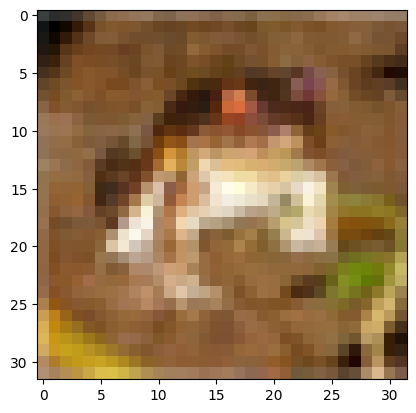

In [ ]:
# Một hình ảnh ví dụ từ tập dữ liệu. Thay giá trị `image_id` để xem một tập ảnh khác!
image_id = 0 
plt.imshow(x_train[image_id, ...])

Ví dụ: Nhãn của 10 điểm dữ liệu trong tập x_train

In [ ]:
print(y_train[:10])

[[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]


#### 2. Tiền xử lý dữ liệu

Định nghĩa các hàm

In [ ]:
# Hàm biến đổi nhãn y từ dạng integer thành dạng one hot 
def list_to_onehot(x, num_class=10):
    onehot = np.zeros([x.shape[0], num_class], dtype=np.float64)
    onehot[np.arange(x.shape[0]), x[:, 0].astype(int)] = 1.0
    return onehot

# Hàm chia dữ liệu train/val theo tỉ lệ rate_train
def split_train_val(x, y, rate_train=0.7):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    i = int(x.shape[0]*rate_train)
    return (x[indices[:i]], y[indices[:i]]), (x[indices[i:]], y[indices[i:]])

# Hàm normalize dữ liệu hình ảnh đơn giản (255 là giá trị tối đa của 1 pixel)
def preprocess_samples(x):
    return x / 255.

Thực hiện tiền xử lý dữ liệu

In [ ]:
# Chia tập dữ liệu huấn luyện thành tập train/val
(x_train, y_train), (x_val, y_val) =  split_train_val(x_train, y_train)


# Normalize dữ liệu
x_train = preprocess_samples(x_train)
x_val = preprocess_samples(x_val)
x_test = preprocess_samples(x_test)


# Chuyển sang dạng one-hot
y_train = list_to_onehot(y_train)
y_val = list_to_onehot(y_val)
y_test = list_to_onehot(y_test)

Ví dụ: Nhãn của 10 điểm dữ liệu sau khi chuyển sang dạng one-hot vector

In [ ]:
for it in y_train[:10]:
    print(it)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


#### 3. Xây dựng mô hình

Dưới đây là một ví dụ về việc tạo ra một Convolutional Neural Network dựa trên kiến trúc của ResNet50 (một CNN nổi tiếng và được áp dụng rộng rãi), trong đó, giữ nguyên kiến trúc ResNet50 và thay thế  layer cuối với 1000 classes thành layer mới với 10 classes (CIFAR-10).

tf.keras.applications.ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(32, 32, 3), pooling=None, classes=10)) là API sẽ trả về model resnet50.
API này có các tham số là:
- include_top: True hoặc False: nếu là True API sẽ trả về model bao gồm phần fully-connected layer đã được huấn luyện. Nếu là False sẽ chỉ trả về phần backbone.
- weights: Nếu là None sẽ trả về model chưa được huấn luyện. Là 'imagenet' sẽ trả về model đã được train trên tập dữ liệu imagenet. Nếu là đường dẫn sẽ trả về model được load weight theo đường dẫn đó (đường dẫn cần chứa bộ weight đúng cấu trúc resnet50.
- input_tensor: là keras tensor được dùng như input của model (các bạn không cần quan tâm tham số này).
- input_shape: shape của input. Chỉ dùng khi include_top = False.
- pooling: Chỉ dùng khi include_top = False. Là 'None' nếu không muốn thay đổi output của resnet50. Là 'avg' nếu muốn áp dụng global average pooling lên output của resnet50. Là 'max' nếu muốn áp dụng global max pooling lên output của resnet50.
- classes: Số classes cần phân loại.

Ở đây ta sẽ khai báo mô hình resnet50 không sử dụng weights train trước (weights = None), không bao gồm phần fully_connected layer (include_top = False). Input_shape = (32, 32, 3) là chiều của ảnh input. 

Output của resnet50 là 1 tensor 4 chiều. Để chuyển nó thành ma trận 2 chiều ta thêm vào mô hình layer tf.keras.layers.Flatten() để làm phẳng tensor 4 chiều thành 2 chiều.

Sau đó thêm vào model layer tf.keras.layers.Dense và tf.keras.layers.Softmax() để output ra xác suất tấm ảnh thuộc class nào.

In [ ]:
def create_model_resnet50():
    # khai báo biến model sequential 
    model = tf.keras.models.Sequential(name='my-restnet50')        
    
    # thêm khối kiến trúc ResNet50 vào từ thư viện TF
    model.add(tf.keras.applications.ResNet50(                       
      include_top=False, weights=None,
      input_tensor=None, 
      input_shape=(32, 32, 3),
      pooling=None, classes=10))
    
    # vector hóa output của mạng ResNet50 (trước đó là tensor đa chiều)
    model.add(tf.keras.layers.Flatten())
    
    # thêm dense layer (fully-connected layer) với 10 classes
    model.add(tf.keras.layers.Dense(10, activation='sigmoid'))
    
    # thêm softmax layer
    model.add(tf.keras.layers.Softmax())                            
    return model

Dựa vào hàm **create_model_resnet50** ở trên, bạn có thể tự xây dựng hàm tạo các mô hình khác.  
Chi tiết thông tin về các mô hình có trong thư viện tf.keras bạn tham khảo ở [các CNN hiện đại trong thư viện TF](https://www.tensorflow.org/api_docs/python/tf/keras/applications)


#### 4. Huấn luyện mô hình

Ở Lần các bước tiếp theo, ta lượt gọi 1 trong 3 hàm tạo mô hình ở trên để:


a.   Tạo ra mô hình CNN tương ứng  
b.   Huấn luyện mô hình, train 8 epochs (lưu ý chạy trên GPU)  
c.   Tính độ chính xác trên tập test  
d.   Lưu kết quả để so sánh  



In [ ]:
# a. Gọi hàm để tạo ra một kiến trúc CNN (chẳng hạn kiến trúc ResNet50)
model = create_model_resnet50() 

In [ ]:
# b.1. Xác định hàm mất mát, hàm tối ưu và tiêu chí đánh giá tập Validation
model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), # hàm mất mát
              optimizer=tf.keras.optimizers.Adam(), # hàm tối ưu
              metrics=['accuracy']) # tiêu chí đánh giá

Model: "my-restnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
 softmax (Softmax)           (None, 10)                0         
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
# b.2. Huấn luyện mô hình và lưu lịch sử.
history = model.fit(x_train,
          y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_val, y_val))

Epoch 1/20
274/274 [==============================] - 70s 75ms/step - loss: 2.0859 - accuracy: 0.2177 - val_loss: 2.4094 - val_accuracy: 0.0963
Epoch 2/20
274/274 [==============================] - 17s 62ms/step - loss: 2.0861 - accuracy: 0.2094 - val_loss: 2.2043 - val_accuracy: 0.1756
Epoch 3/20
274/274 [==============================] - 18s 66ms/step - loss: 2.0596 - accuracy: 0.2151 - val_loss: 2.3326 - val_accuracy: 0.1291
Epoch 4/20
274/274 [==============================] - 17s 63ms/step - loss: 2.0769 - accuracy: 0.2100 - val_loss: 2.3369 - val_accuracy: 0.1351
Epoch 5/20
274/274 [==============================] - 18s 67ms/step - loss: 2.0770 - accuracy: 0.2071 - val_loss: 2.1657 - val_accuracy: 0.1455
Epoch 6/20
274/274 [==============================] - 18s 67ms/step - loss: 2.1134 - accuracy: 0.1856 - val_loss: 2.3280 - val_accuracy: 0.1212
Epoch 7/20
274/274 [==============================] - 18s 64ms/step - loss: 2.1084 - accuracy: 0.1967 - val_loss: 2.0710 - val_accuracy:

#### 5. Đánh giá mô hình

In [ ]:
# c. Đánh giá một mô hình cụ thể
results = model.evaluate(x_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 2.1490 - accuracy: 0.1848


In [ ]:
# d. Lưu kết quả "accuracy" của mô hình (nằm ở giá trị results[1] ở bước trước đó)

### TODO 1: res_effnet
Các bạn hoàn thành việc khởi tạo mô hình `EfficientNet_B7`, huấn luyện và đánh giá.

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense

input_shape = (64, 64, 3)
# Khởi tạo mô hình EfficientNetB7
effnet = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Thêm lớp Dense ở cuối để phù hợp với số lượng lớp của tập dữ liệu
model_effnet = Sequential()
model_effnet.add(effnet)
model_effnet.add(GlobalAveragePooling2D())
num_classes = 10
model_effnet.add(Dense(num_classes, activation='softmax'))

# Compile mô hình
model_effnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Huấn luyện mô hình
model_effnet.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=128)

# Đánh giá mô hình
_, res_effnet = model_effnet.evaluate(x_test, y_test)


### TODO 2: res_mobnet
Các bạn hoàn thành việc khởi tạo mô hình `MobileNet_V2`, huấn luyện và đánh giá.


In [ ]:
# Import MobileNetV2 model
from tensorflow.keras.applications import MobileNetV2

input_shape = (64, 64, 3)
# Instantiate the model
mobnet_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Add additional layers
model = keras.Sequential()
model.add(mobnet_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.5))
num_classes = 10
model.add(keras.layers.Dense(num_classes, activation='softmax')) # num_classes is the number of your classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
res_mobnet = test_acc


Vẽ biểu đồ so sánh độ chính xác của 3 mô hình.

In [ ]:
model_names = ['ResNet50', 'EfficientNetB7', 'MobileNetV2']
'''
Cập nhật độ chính xác trên test set vào accuracies, tương ứng thứ tự trong model_names
'''
accuracies = [0, 0, 0] # thay thế bằng độ chính xác của [res_resnet, res_effnet, res_mobnet]
plt.bar(np.arange(len(model_names)), accuracies, align='center', width=0.5, color='green')
plt.xticks(np.arange(len(model_names)), model_names, rotation=45)
plt.title('Accuracy in test set after 1 epoch')

## 🎉 Chúc mừng bạn đã hoàn thành bài tutorial tuần này!